In [11]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

In [12]:
train_dir = "../data/final/train"
test_dir  = "../data/final/test"

img_size = (224, 224)
batch_size = 16

from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'  # assuming you're using sparse categorical crossentropy
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)


Found 9252 images belonging to 257 classes.
Found 514 images belonging to 257 classes.


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
NUM_CLASSES = len(os.listdir(train_dir))

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-16]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax', 
                    kernel_regularizer=regularizers.l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,                 
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_fingerprint_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[lr_scheduler, early_stopping]
)



Epoch 1/100
579/579 [==============================] - 181s 305ms/step - loss: 7.2319 - accuracy: 0.0324 - val_loss: 6.3828 - val_accuracy: 0.1012 - lr: 1.0000e-04
Epoch 2/100
579/579 [==============================] - 102s 175ms/step - loss: 5.4869 - accuracy: 0.1635 - val_loss: 4.9377 - val_accuracy: 0.2529 - lr: 1.0000e-04
Epoch 3/100
579/579 [==============================] - 106s 184ms/step - loss: 4.3898 - accuracy: 0.3061 - val_loss: 4.2740 - val_accuracy: 0.3405 - lr: 1.0000e-04
Epoch 4/100
579/579 [==============================] - 106s 184ms/step - loss: 3.7485 - accuracy: 0.4320 - val_loss: 3.8168 - val_accuracy: 0.4241 - lr: 1.0000e-04
Epoch 5/100
579/579 [==============================] - 107s 185ms/step - loss: 3.3658 - accuracy: 0.5057 - val_loss: 3.6501 - val_accuracy: 0.4416 - lr: 1.0000e-04
Epoch 6/100
579/579 [==============================] - 107s 185ms/step - loss: 3.0822 - accuracy: 0.5677 - val_loss: 3.4500 - val_accuracy: 0.4844 - lr: 1.0000e-04
Epoch 7/100
579/

In [14]:
loss, accuracy = model.evaluate(test_generator)
print(f"\n Test Loss: {loss:.4f}")
print(f" Test Accuracy: {accuracy:.4f}")

33/33 [==============================] - 2s 58ms/step - loss: 2.3792 - accuracy: 0.6342

 Test Loss: 2.3792
 Test Accuracy: 0.6342


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
X_test = []
y_test = []

steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

for i in range(steps):
    x, y = next(test_generator)
    X_test.append(x)
    y_test.append(y)

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

y_pred_probs = model.predict(X_test, batch_size=16)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

33/33 [==============================] - 2s 29ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000         2
         1.0     0.0000    0.0000    0.0000         2
         2.0     1.0000    1.0000    1.0000         2
         3.0     1.0000    1.0000    1.0000         2
         4.0     0.5000    1.0000    0.6667         2
         5.0     1.0000    1.0000    1.0000         2
         6.0     0.3333    0.5000    0.4000         2
         7.0     0.3333    0.5000    0.4000         2
         8.0     0.4000    1.0000    0.5714         2
         9.0     1.0000    0.5000    0.6667         2
        10.0     0.5000    0.5000    0.5000         2
        11.0     0.5000    0.5000    0.5000         2
        12.0     1.0000    1.0000    1.0000         2
        13.0     1.0000    0.5000    0.6667         2
        14.0     1.0000    1.0000    1.0000         2
        15.0     1.0000    1.0000    1.0000         2
   

c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

report = classification_report(y_test, y_pred, output_dict=True)

precision_macro = report['macro avg']['precision']
recall_macro = report['macro avg']['recall']
f1_macro = report['macro avg']['f1-score']

precision_weighted = report['weighted avg']['precision']
recall_weighted = report['weighted avg']['recall']
f1_weighted = report['weighted avg']['f1-score']

print(f"\nMacro Avg - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1 Score: {f1_macro:.4f}")
print(f"Weighted Avg - Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1 Score: {f1_weighted:.4f}")



Classification Report:
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000         2
         1.0     0.0000    0.0000    0.0000         2
         2.0     1.0000    1.0000    1.0000         2
         3.0     1.0000    1.0000    1.0000         2
         4.0     0.5000    1.0000    0.6667         2
         5.0     1.0000    1.0000    1.0000         2
         6.0     0.3333    0.5000    0.4000         2
         7.0     0.3333    0.5000    0.4000         2
         8.0     0.4000    1.0000    0.5714         2
         9.0     1.0000    0.5000    0.6667         2
        10.0     0.5000    0.5000    0.5000         2
        11.0     0.5000    0.5000    0.5000         2
        12.0     1.0000    1.0000    1.0000         2
        13.0     1.0000    0.5000    0.6667         2
        14.0     1.0000    1.0000    1.0000         2
        15.0     1.0000    1.0000    1.0000         2
        16.0     1.0000    1.0000    1.0000         2
   

c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENO

1/1 [==============================] - 0s 27ms/step


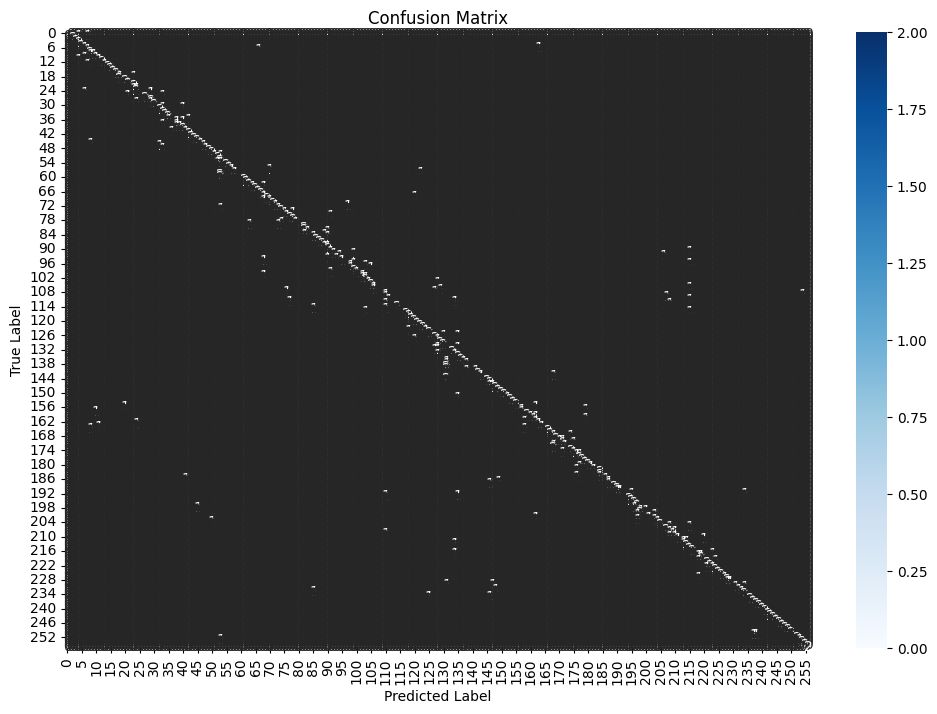

In [17]:
# run abis code block bawah
import seaborn as sns
import matplotlib.pyplot as plt
y_true = []
y_pred = []

test_generator.reset()
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

for _ in range(steps):
    x_batch, y_batch = next(test_generator)

    if y_batch.ndim > 1:
        y_true.extend(np.argmax(y_batch, axis=1))
    else:
        y_true.extend(y_batch)
    
    preds = model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()